# High Rayleigh number resolution tests, continued

- I am now able to use existing data to initialise new simulations, even at different resolutions
- Model stability is more sensitive to changes in vertical resolution than horizontal resolution
- If we keep $N_z \geq 128$, we can avoid increasing the hyperdiffusivity
- In this notebook, I test a range of $N_x$ and also try increasing $N_z$ to 192 to explore the possibility that the vertical resolution was insufficient to start with

In [1]:
import importlib

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import dask

from modules import stats
import modules.regridding

importlib.reload(stats)
importlib.reload(modules.regridding)

from modules.regridding import Regridder

## Model runs

In [2]:
nx0 = 1024
nz0 = 128
dt0 = 2e-3
alpha = 8

nx = np.array([256, 384, 512, 768, 1024])
nz = np.array([128, 192])
nx, nz = np.meshgrid(nx, nz)
dt = (nx0/alpha + nz0)/(nx/alpha + nz)*dt0
dt = np.round(dt*1e3, 2)

print('(N_x, N_z, dt):')
with np.printoptions(suppress=True):
    print(np.array(list(zip(nx.flat, nz.flat, dt.flat))))

(N_x, N_z, dt):
[[ 256.    128.      3.2 ]
 [ 384.    128.      2.91]
 [ 512.    128.      2.67]
 [ 768.    128.      2.29]
 [1024.    128.      2.  ]
 [ 256.    192.      2.29]
 [ 384.    192.      2.13]
 [ 512.    192.      2.  ]
 [ 768.    192.      1.78]
 [1024.    192.      1.6 ]]


In [14]:
data = {}
for nx in [256, 384, 512, 768, 1024]:
    for nz in [128, 192]:
        if (nx, nz) == (1024, 128):
            continue
        name = f'{nx}_{nz}/*.nc'
        ds = xr.open_mfdataset(
            f'../data/restest_highRa_v2/{name}',
            chunks={'t': 100, 'x': -1, 'z': -1})
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            ds = ds.drop_duplicates('t')
        data[(nx, nz)] = ds

ds = xr.open_mfdataset('../data/highRa_tests/nonlinear_hyper_test/*.nc')
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ds = ds.drop_duplicates('t')
data[(1024, 128)] = ds

## Statistics
- As usual, all runs are coarse-grained to the resolution of the coarsest run before calculating statistics

In [8]:
nx = [256, 384, 512, 768, 1024]
nz = [128, 192]
w_quantiles = xr.DataArray(
    name='quantiles',
    coords={'nx': nx, 'nz': nz},
    dims=['nx', 'nz'],
)
theta_quantiles = w_quantiles.copy()
for res in data.keys():
    regridder = Regridder(data[res], data[(256, 128)], ('x',))
    t_range = (data[res].t[-1] - 50., data[res].t[-1])
    w_quantile = stats.level_quantile(
        data[res].w, 0.5, 0.99, t_range, regridder)
    theta_quantile = stats.level_quantile(
        data[res].theta, 0.5, 0.99, t_range, regridder)
    w_quantiles.loc[dict(nx=res[0], nz=res[1])] = w_quantile
    theta_quantiles.loc[dict(nx=res[0], nz=res[1])] = theta_quantile

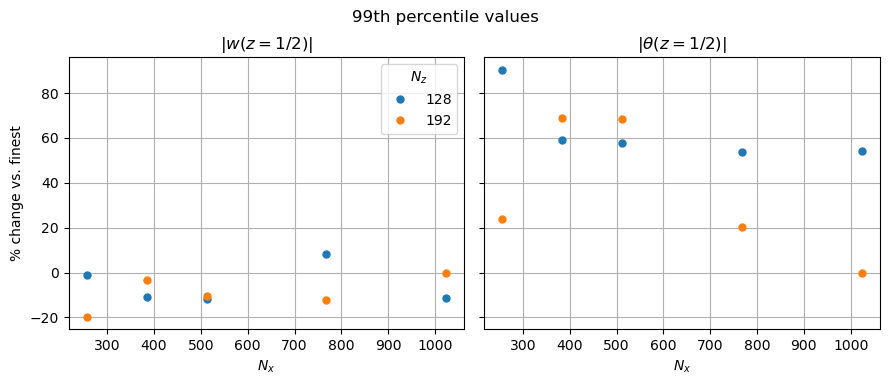

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

da = (w_quantiles/w_quantiles.sel(nx=1024, nz=192) - 1)*1e2
da = da.transpose('nx', 'nz')
axes[0].plot(da.nx, da.data, '.', markersize=10, label=da.nz.data)
axes[0].grid()
axes[0].set(
    xlabel='$N_x$',
    ylabel=r'% change vs. finest',
    title=r'$|w(z=1/2)|$',
)
axes[0].legend(title='$N_z$')

da = (theta_quantiles/theta_quantiles.sel(nx=1024, nz=192) - 1)*1e2
da = da.transpose('nx', 'nz')
axes[1].plot(da.nx, da.data, '.', markersize=10)
axes[1].grid()
axes[1].set(
    xlabel='$N_x$',
    title=r'$|\theta(z=1/2)|$')

fig.suptitle('99th percentile values', y=0.95)
fig.tight_layout()

In [25]:
nx = [256, 384, 512, 768, 1024]
nz = [128, 192]
w_quantiles = xr.DataArray(
    name='quantiles',
    coords={'nx': nx, 'nz': nz},
    dims=['nx', 'nz'],
)
theta_quantiles = w_quantiles.copy()
for res in data.keys():
    regridder = Regridder(data[res], data[(256, 128)], ('x',))
    t_range = (data[res].t[-1] - 50., data[res].t[-1])
    w_quantile = stats.level_quantile(
        data[res].w, 0.5, 0.95, t_range, regridder)
    theta_quantile = stats.level_quantile(
        data[res].theta, 0.5, 0.95, t_range, regridder)
    w_quantiles.loc[dict(nx=res[0], nz=res[1])] = w_quantile
    theta_quantiles.loc[dict(nx=res[0], nz=res[1])] = theta_quantile

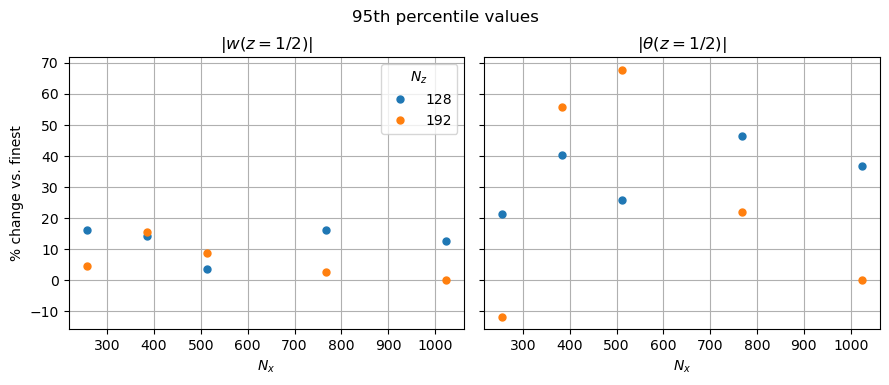

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

da = (w_quantiles/w_quantiles.sel(nx=1024, nz=192) - 1)*1e2
da = da.transpose('nx', 'nz')
axes[0].plot(da.nx, da.data, '.', markersize=10, label=da.nz.data)
axes[0].grid()
axes[0].set(
    xlabel='$N_x$',
    ylabel=r'% change vs. finest',
    title=r'$|w(z=1/2)|$',
)
axes[0].legend(title='$N_z$')

da = (theta_quantiles/theta_quantiles.sel(nx=1024, nz=192) - 1)*1e2
da = da.transpose('nx', 'nz')
axes[1].plot(da.nx, da.data, '.', markersize=10)
axes[1].grid()
axes[1].set(
    xlabel='$N_x$',
    title=r'$|\theta(z=1/2)|$')

fig.suptitle('95th percentile values', y=0.95)
fig.tight_layout()

## Temperature profiles

In [27]:
profiles = {}
for res in data.keys():
    profiles[res] = data[res].theta.mean(('x', 't')).compute()


[Text(0.5, 0, '$\\theta$'),
 Text(0, 0.5, '$z$'),
 Text(0.5, 1.0, '$\\theta(z)$ for 1024 x 192 run')]

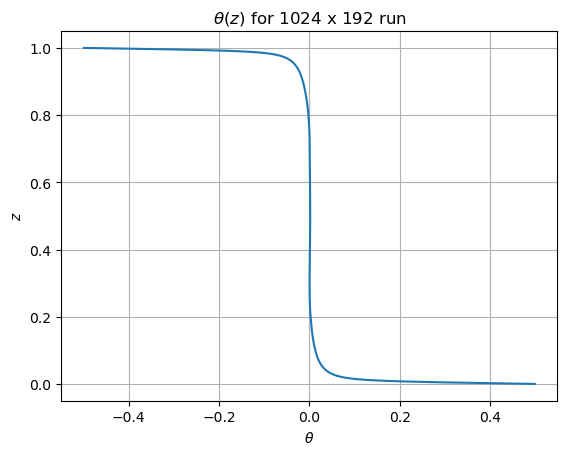

In [33]:
fig, ax = plt.subplots()
ax.plot(profiles[(1024, 192)], profiles[(1024, 192)].z)
ax.grid()
ax.set(
    xlabel=r'$\theta$', ylabel='$z$',
    title=r'$\theta(z)$ for 1024 x 192 run')

### $N_x$ dependence

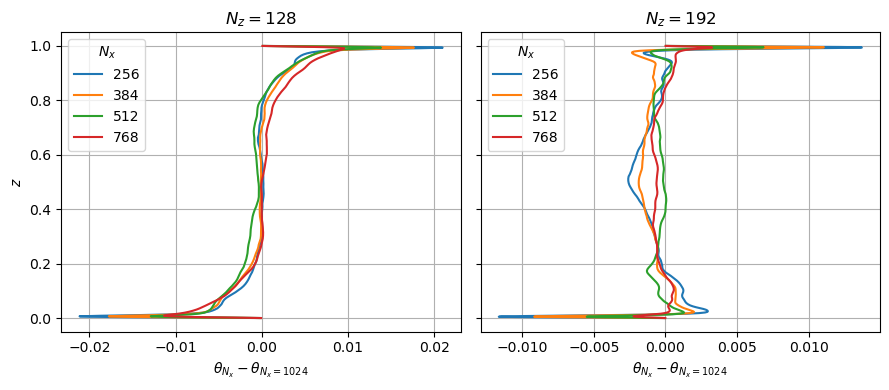

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)


for nx in [256, 384, 512, 768]:
    da = profiles[(nx, 128)] - profiles[(1024, 128)]
    axes[0].plot(da, da.z, label=nx)
axes[0].legend(title='$N_x$')
axes[0].grid()
axes[0].set(
    xlabel=r'$\theta_{N_x} - \theta_{N_x = 1024}$', ylabel='$z$',
    title='$N_z = 128$')

for nx in [256, 384, 512, 768]:
    da = profiles[(nx, 192)] - profiles[(1024, 192)]
    axes[1].plot(da, da.z, label=nx)
axes[1].legend(title='$N_x$')
axes[1].grid()
axes[1].set(xlabel=r'$\theta_{N_x} - \theta_{N_x = 1024}$', title='$N_z = 192$')

fig.tight_layout()

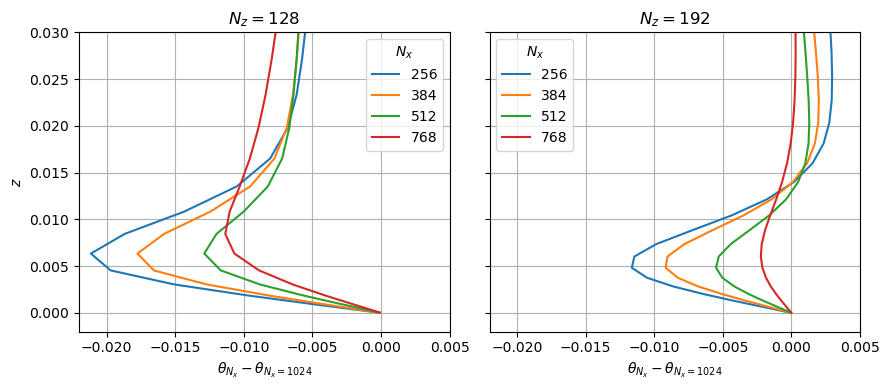

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
xlim = (-0.022, 0.005)
ylim = (-0.002, 0.03)

for nx in [256, 384, 512, 768]:
    da = profiles[(nx, 128)] - profiles[(1024, 128)]
    axes[0].plot(da, da.z, label=nx)
axes[0].legend(title='$N_x$')
axes[0].grid()
axes[0].set(
    xlabel=r'$\theta_{N_x} - \theta_{N_x = 1024}$', ylabel='$z$',
    title='$N_z = 128$', xlim=xlim, ylim=ylim,
)

for nx in [256, 384, 512, 768]:
    da = profiles[(nx, 192)] - profiles[(1024, 192)]
    axes[1].plot(da, da.z, label=nx)
axes[1].legend(title='$N_x$')
axes[1].grid()
axes[1].set(
    xlabel=r'$\theta_{N_x} - \theta_{N_x = 1024}$', title='$N_z = 192$',
    xlim=xlim, ylim=ylim,
)

fig.tight_layout()

### $N_z$ dependence

[Text(0.5, 0, '$\\theta_{N_x, N_z = 128} - \\theta_{N_x, N_z = 192}$'),
 Text(0, 0.5, '$z$')]

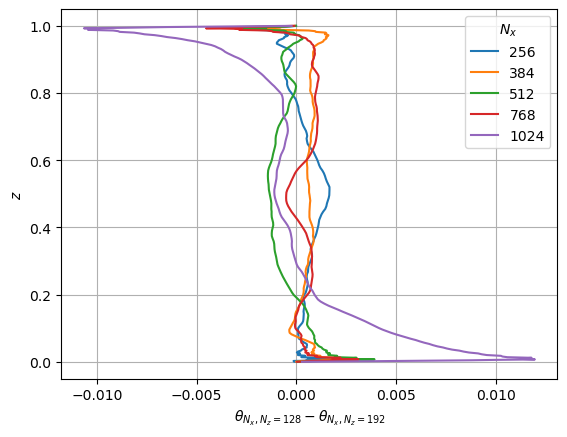

In [61]:
fig, ax = plt.subplots()

for nx in [256, 384, 512, 768, 1024]:
    fine = profiles[(nx, 192)]
    coarse = profiles[(nx, 128)].interp(z=fine.z)
    ax.plot(coarse - fine, fine.z, label=nx)

ax.legend(title='$N_x$')
ax.grid()
ax.set(
    xlabel=r'$\theta_{N_x, N_z = 128} - \theta_{N_x, N_z = 192}$',
    ylabel='$z$')

[Text(0.5, 0, '$\\theta_{N_x, N_z = 128} - \\theta_{N_x, N_z = 192}$'),
 Text(0, 0.5, '$z$'),
 (-0.001, 0.013),
 (-0.005, 0.2)]

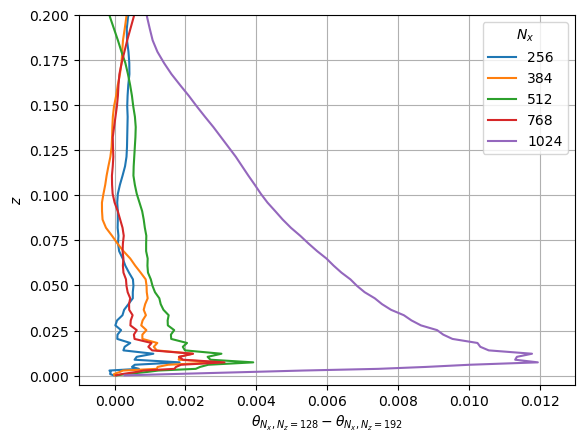

In [62]:
fig, ax = plt.subplots()

for nx in [256, 384, 512, 768, 1024]:
    fine = profiles[(nx, 192)]
    coarse = profiles[(nx, 128)].interp(z=fine.z)
    ax.plot(coarse - fine, fine.z, label=nx)

ax.legend(title='$N_x$')
ax.grid()
ax.set(
    xlabel=r'$\theta_{N_x, N_z = 128} - \theta_{N_x, N_z = 192}$',
    ylabel='$z$', xlim=(-0.001, 0.013), ylim=(-0.005, 0.2))

### Combined dependence

[Text(0.5, 0, '$\\theta_{N_x, N_z} - \\theta_{N_x = 1024, N_z = 192}$'),
 Text(0, 0.5, '$z$')]

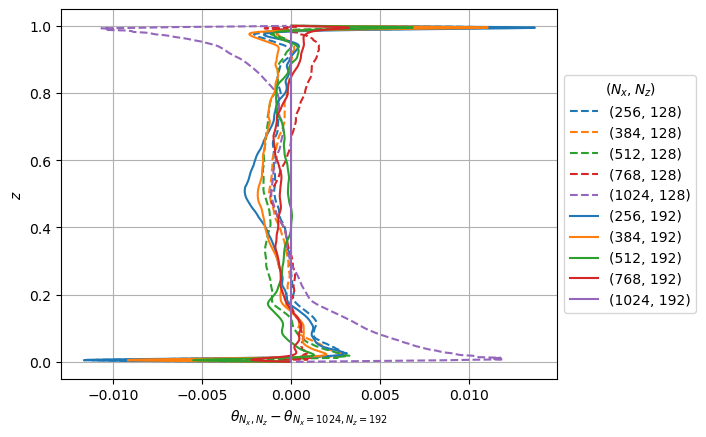

In [66]:
fig, ax = plt.subplots()
fine = profiles[(1024, 192)]

for nx in [256, 384, 512, 768, 1024]:
    coarse = profiles[(nx, 128)].interp(z=fine.z)
    ax.plot(coarse - fine, fine.z, label=f'({nx}, 128)', linestyle='--')

ax.set_prop_cycle(None)
for nx in [256, 384, 512, 768, 1024]:
    coarse = profiles[(nx, 192)]
    ax.plot(coarse - fine, fine.z, label=f'({nx}, 192)')

ax.legend(title='$(N_x, N_z)$', loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()
ax.set(
    xlabel=r'$\theta_{N_x, N_z} - \theta_{N_x = 1024, N_z = 192}$',
    ylabel='$z$')

[Text(0.5, 0, '$\\theta_{N_x, N_z} - \\theta_{N_x = 1024, N_z = 192}$'),
 Text(0, 0.5, '$z$'),
 (-0.02, 0.1)]

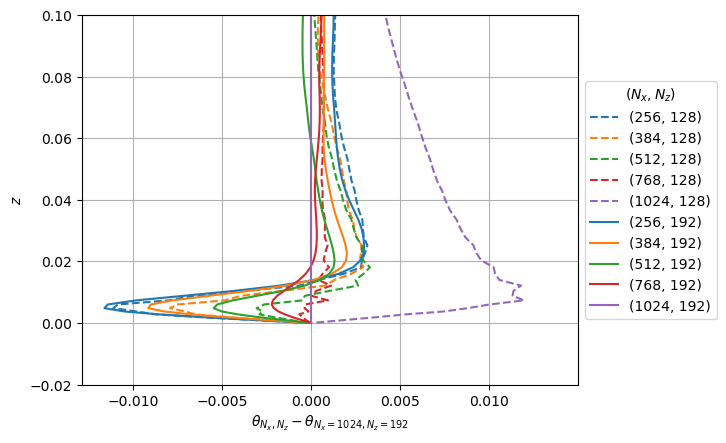

In [68]:
fig, ax = plt.subplots()
fine = profiles[(1024, 192)]

for nx in [256, 384, 512, 768, 1024]:
    coarse = profiles[(nx, 128)].interp(z=fine.z)
    ax.plot(coarse - fine, fine.z, label=f'({nx}, 128)', linestyle='--')

ax.set_prop_cycle(None)
for nx in [256, 384, 512, 768, 1024]:
    coarse = profiles[(nx, 192)]
    ax.plot(coarse - fine, fine.z, label=f'({nx}, 192)')

ax.legend(title='$(N_x, N_z)$', loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()
ax.set(
    xlabel=r'$\theta_{N_x, N_z} - \theta_{N_x = 1024, N_z = 192}$',
    ylabel='$z$', ylim=(-0.02, 0.1))

## Conclusions
- Temperature extremes seem more sensitive to changes in resolution than velocity extremes
- For $N_x > 512$, the runs with lower vertical resolution ($N_z = 128$) are generally overestimating the extremes
    - It also looks like there is a substantial horizontal resoluton dependence for temperature
    - I should investigate this parameter range further
- Hopefully I will not need to complicate things further by changing the BCs
- It looks like it will be difficult to achieve a stable coarse model with truly sub-grid unresolved scales
    - More like parametrisation in the grey zone

- Check vertical temperature profile
- Reduce and increase horizontal resolution?